In [1]:
"""Process comparison of healthy and impaired for PLOS."""
import os
import argparse
import sys
sys.path.append('..')
from bayescmd.results_handling import comparison_kde_plot
from bayescmd.results_handling import data_import
from bayescmd.abc import import_actual_data
from bayescmd.abc import priors_creator
from bayescmd.util import findBaseDir
import json
from distutils import dir_util

BASEDIR = os.path.abspath(findBaseDir('BayesCMD'))

STARTING AT: /home/buck06191/repos/GitHub/BayesCMD/bayescmd
 Looking for: BayesCMD
STARTING AT: /home/buck06191/repos/GitHub/BayesCMD/bayescmd
 Looking for: BayesCMD
STARTING AT: /home/buck06191/repos/GitHub/BayesCMD/bayescmd
 Looking for: BayesCMD
STARTING AT: /home/buck06191/repos/GitHub/BayesCMD/bayescmd
 Looking for: BayesCMD


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
healthy_Dir = "/home/buck06191/Dropbox/phd/PLOS_paper/data/parameters/healthy/wide_params/NRMSE_SA_second"
impaired_Dir = "/home/buck06191/Dropbox/phd/PLOS_paper/data/parameters/impaired/wide_params/NRMSE_SA"
healthy_pfile = os.path.abspath(os.path.join(healthy_Dir, 'all_parameters.csv'))
impaired_pfile = os.path.abspath(os.path.join(impaired_Dir, 'all_parameters.csv'))

config_file="../examples/configuration_files/varying_parameter_wide_config.json"
with open(config_file, 'r') as conf_f:
    conf = json.load(conf_f)
params = conf['priors']

input_path = os.path.join(BASEDIR,
                          'PLOS_paper',
                          'data',
                          'simulated_smooth_combined_ABP.csv')

d0 = import_actual_data(input_path)

targets = conf['targets']
model_name = conf['model_name']
inputs = conf['inputs']

config = {
    "model_name": model_name,
    "targets": targets,
    "inputs": inputs,
    "parameters": params,
    "input_path": input_path,
    "zero_flag": {k: False for k in targets}
}

results_healthy = data_import(healthy_pfile)
results_impaired = data_import(impaired_pfile)

Number of lines:	1053945
Number of NaN values:	0
Number of lines:	999000
Number of NaN values:	0


In [4]:
results_healthy.columns

Index(['r_m', 'v_pn', 'sigma_coll', 'p_tot', 'r_t', 'Vol_mit', 'cytox_tot_tis',
       'r_0', 'v_cn', 'T_max0', 'Xtot', 'Dp_n', 'a_n', 'K_sigma', 'R_autp',
       'K_G', 'k_aut', 'euclidean', 'manhattan', 'MSE', 'RMSE', 'NRMSE', 'MAE',
       'Vmca_euclidean', 'Vmca_manhattan', 'Vmca_MSE', 'Vmca_RMSE',
       'Vmca_NRMSE', 'Vmca_MAE', 'CCO_euclidean', 'CCO_manhattan', 'CCO_MSE',
       'CCO_RMSE', 'CCO_NRMSE', 'CCO_MAE', 'TOI_euclidean', 'TOI_manhattan',
       'TOI_MSE', 'TOI_RMSE', 'TOI_NRMSE', 'TOI_MAE', 'ix', 'Batch'],
      dtype='object')

In [5]:
results_impaired.columns

Index(['r_m', 'v_pn', 'sigma_coll', 'p_tot', 'r_t', 'Vol_mit', 'cytox_tot_tis',
       'r_0', 'v_cn', 'T_max0', 'Xtot', 'Dp_n', 'a_n', 'K_sigma', 'R_autp',
       'K_G', 'k_aut', 'euclidean', 'manhattan', 'MSE', 'RMSE', 'NRMSE', 'MAE',
       'Vmca_euclidean', 'Vmca_manhattan', 'Vmca_MSE', 'Vmca_RMSE',
       'Vmca_NRMSE', 'Vmca_MAE', 'CCO_euclidean', 'CCO_manhattan', 'CCO_MSE',
       'CCO_RMSE', 'CCO_NRMSE', 'CCO_MAE', 'TOI_euclidean', 'TOI_manhattan',
       'TOI_MSE', 'TOI_RMSE', 'TOI_NRMSE', 'TOI_MAE', 'ix', 'Batch'],
      dtype='object')

In [6]:
results = pd.concat([results_healthy, results_impaired])

In [7]:
ar_state = ['Healthy'] * results_healthy.shape[0]
ar_state.extend(['Impaired'] * results_impaired.shape[0])
results['Autoregulatory State'] = ar_state
results['Autoregulatory State'] = results['Autoregulatory State'].astype('category')

In [8]:
results.columns

Index(['r_m', 'v_pn', 'sigma_coll', 'p_tot', 'r_t', 'Vol_mit', 'cytox_tot_tis',
       'r_0', 'v_cn', 'T_max0', 'Xtot', 'Dp_n', 'a_n', 'K_sigma', 'R_autp',
       'K_G', 'k_aut', 'euclidean', 'manhattan', 'MSE', 'RMSE', 'NRMSE', 'MAE',
       'Vmca_euclidean', 'Vmca_manhattan', 'Vmca_MSE', 'Vmca_RMSE',
       'Vmca_NRMSE', 'Vmca_MAE', 'CCO_euclidean', 'CCO_manhattan', 'CCO_MSE',
       'CCO_RMSE', 'CCO_NRMSE', 'CCO_MAE', 'TOI_euclidean', 'TOI_manhattan',
       'TOI_MSE', 'TOI_RMSE', 'TOI_NRMSE', 'TOI_MAE', 'ix', 'Batch',
       'Autoregulatory State'],
      dtype='object')

In [9]:
d = "euclidean"#"NRMSE"
figPath = "/home/buck06191/Dropbox/phd/Bayesian_fitting/{}/{}/{}/"\
    "Figures/{}".format(model_name, 'PLOS_paper', 'Comparison', d)

dir_util.mkpath(figPath)

lim = 1000
limit = lim
groups = results['Autoregulatory State'].unique()
acceptance_param=1
group_names= groups

In [10]:
df_list = [results_healthy, results_impaired]
p_names = list(params.keys())

kde_dfs = []
for ii, df in enumerate(df_list):
    sorted_df = df.sort_values(by=d)

    if limit:
        accepted_limit = limit
    elif frac:
        accepted_limit = frac_calculator(sorted_df, frac)
    else:
        raise ValueError('No limit or fraction given.')

    sorted_df['Accepted'] = np.zeros(len(sorted_df))
    sorted_df['Accepted'].iloc[:accepted_limit] = 1
    sorted_df.loc[:, 'Accepted'][sorted_df[d] == 100000] = 2

    kde_dfs.append(sorted_df.loc[(sorted_df['Accepted'] == acceptance_param), :])
    kde_dfs[ii]['Group'] = [ii] * accepted_limit

kde_df = pd.concat(kde_dfs)

if group_names:
    kde_df['Group']= kde_df['Group'].map(lambda x: "{}".format(group_names[x]))
groups = kde_df['Group'].unique()
colors = sns.color_palette("hls", len(groups))
color_pal = dict(zip(groups, colors))


/home/buck06191/.virtualenvs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/buck06191/.virtualenvs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/buck06191/.virtualenvs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

In [11]:
%matplotlib inline
# g = sns.PairGrid(
#             kde_df,
#             vars=p_names,
#             hue="Group",
#             hue_kws={"cmap":['Blues', 'Reds']},
#             palette=color_pal,
#             diag_sharey=False)
# g.map_diag(sns.distplot)
# g.map_lower(sns.kdeplot)


/home/buck06191/.virtualenvs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
../bayescmd/results_handling.py:732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sorted_df.loc[:, 'Accepted'][sorted_df[d] == 100000] = 2
../bayescmd/results_handling.py:736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  kde_dfs[ii]['Group'] = [ii]

{'Healthy': 'b', 'Impaired': 'r'}
['Blues', 'Reds']


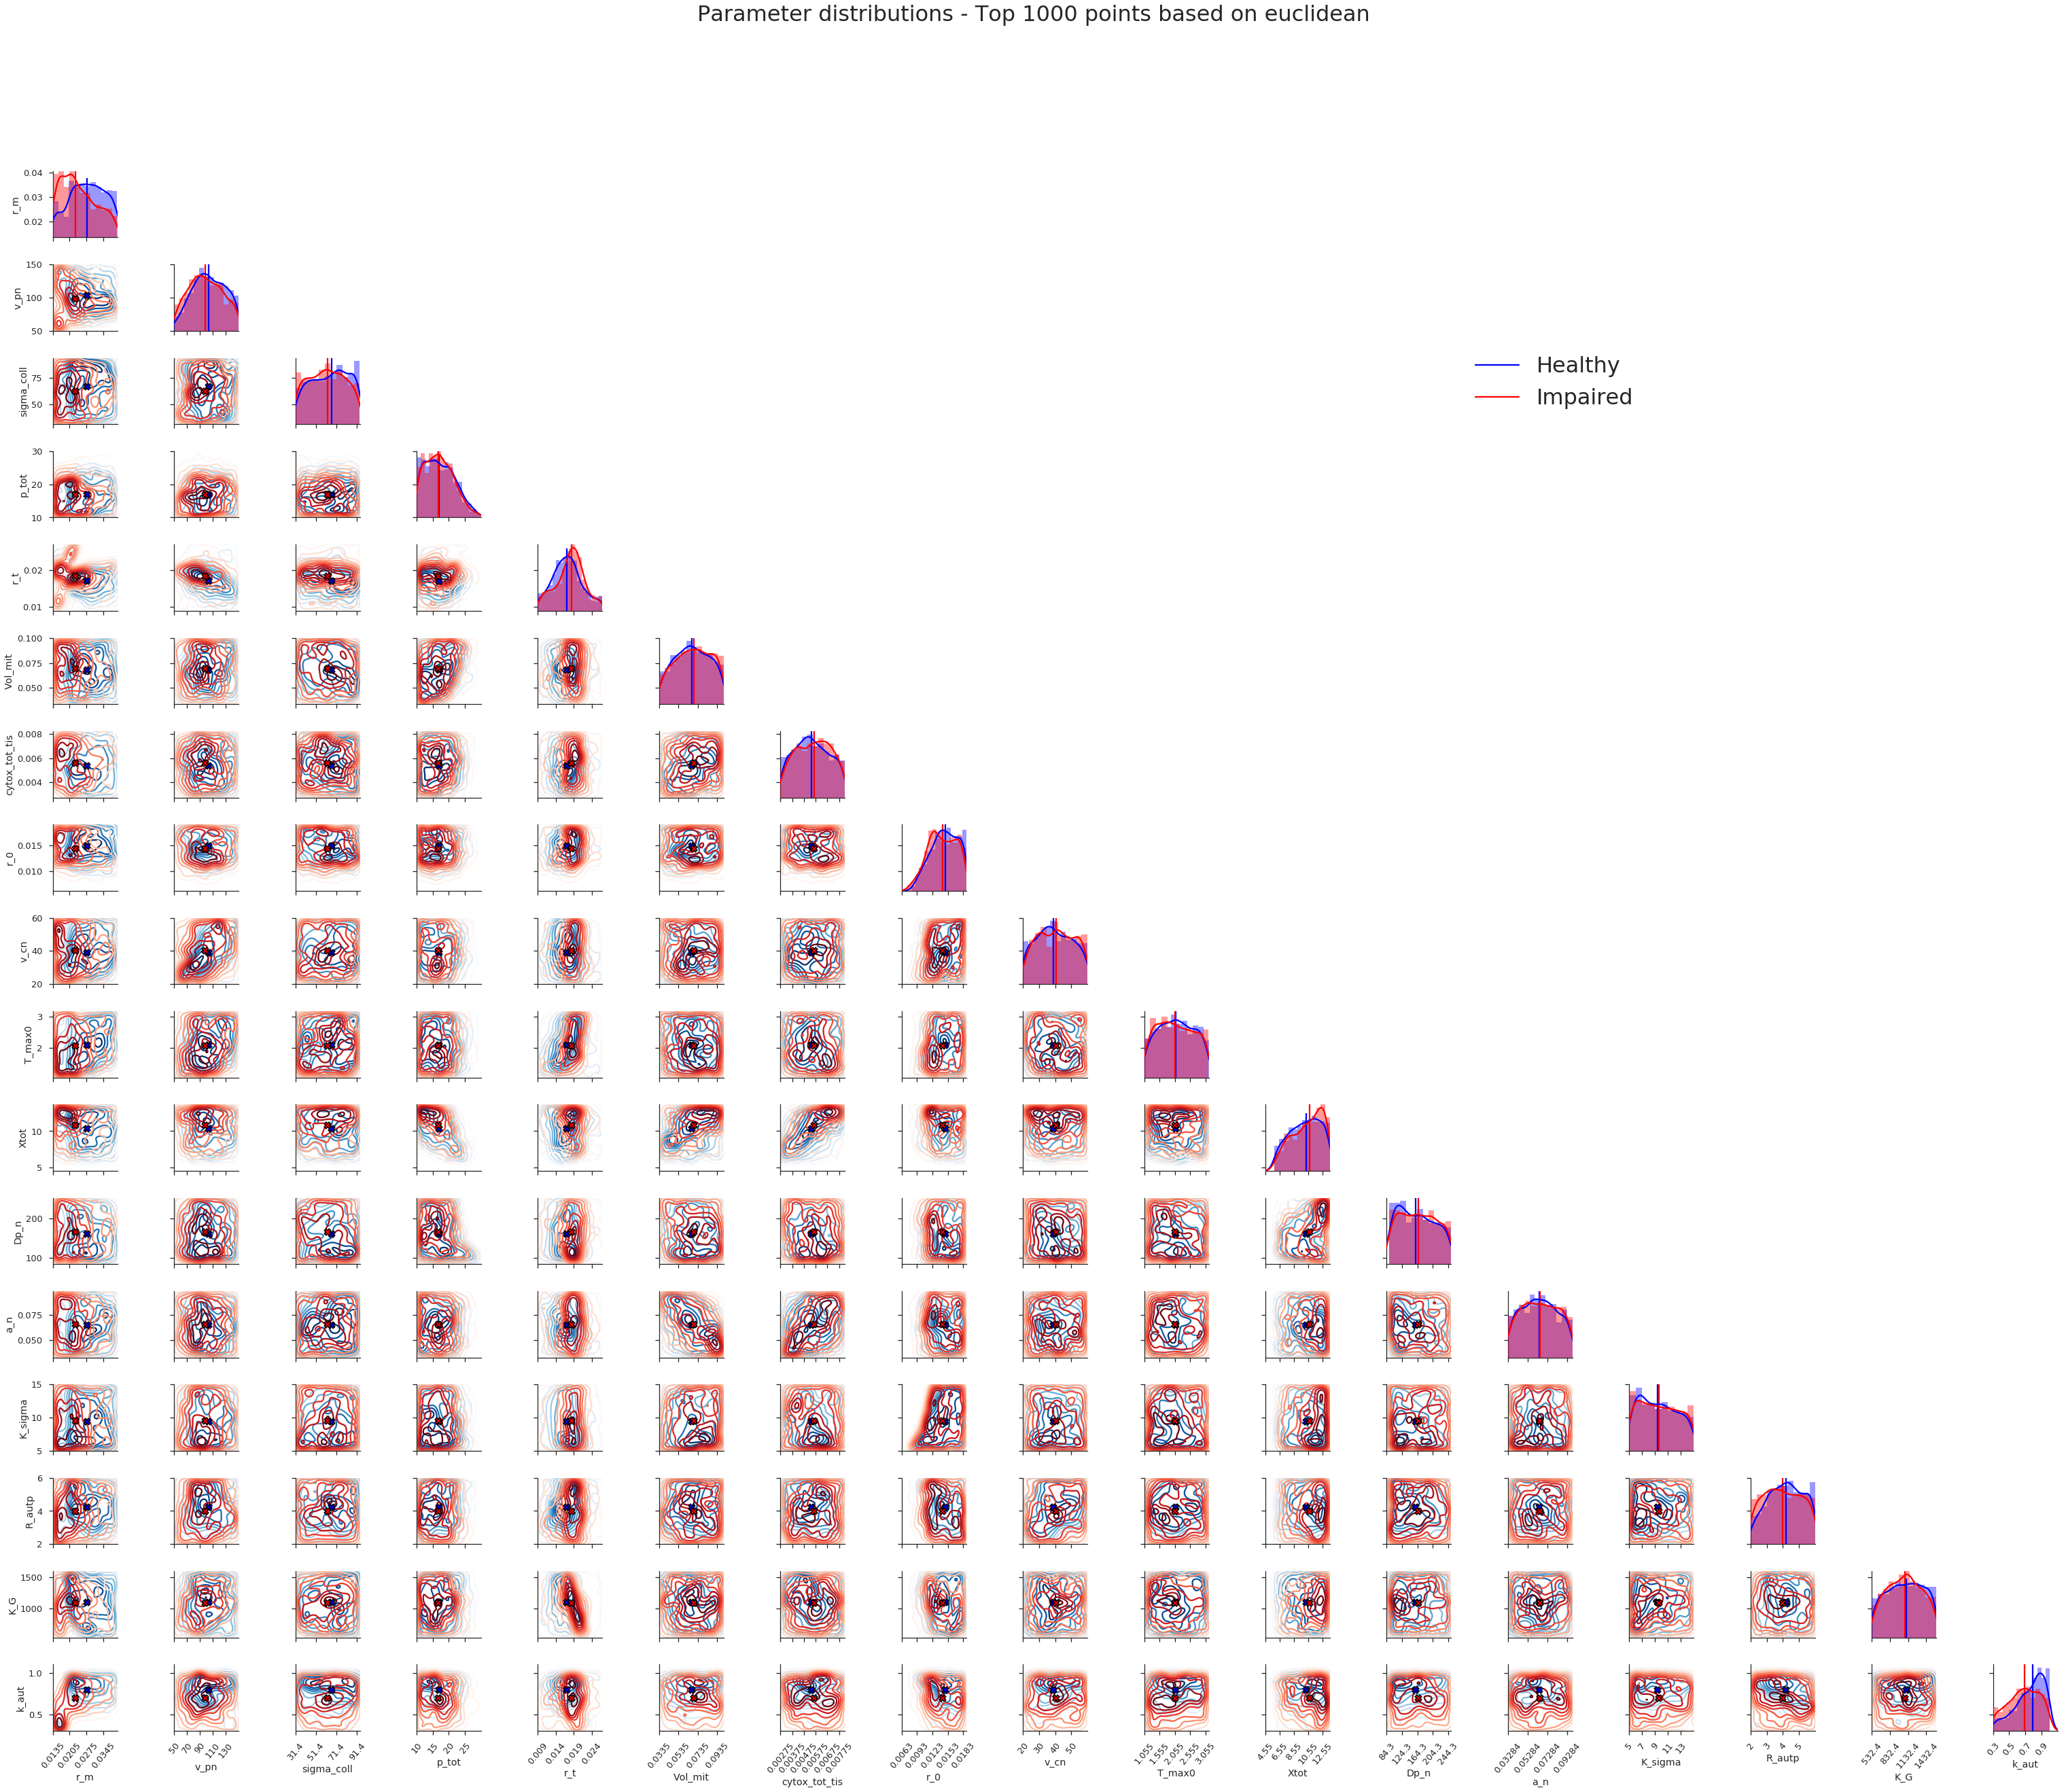

In [12]:
comparison_kde_plot(df_list, params, group_names=list(groups), limit=lim, n_ticks=4, d=d,
                 median_file=os.path.join(figPath, "medians.txt"))